# Getting bylines from the New York Times 

This is the final version of the code I used to write [this piece](link). The project structure is like this: 

- Get archive data 
- Use regex to parse the `lead paragraph` column 
- Clean the results and geocode them 
- Merge geographic data back to original archive dataframe 


---
<br> </br>


## Downloading the archive

I've already downloaded the archive for this project, stored in the `data` folder. We can use the following script to reproduce it: 

```python
# setup 

import os
import us 
import pandas as pd 
import numpy as np 
import json 
import requests 
import configparser as cp
from time import sleep
from datetime import datetime

from tqdm import tqdm

parser = cp.ConfigParser()
parser.read('creds.cfg')

# for api calls 
nyt_key = parser['KEYS']['NYT_KEY']



# download archive with the following

def get_archive(year, month): 
    """Gets archived NYT stories from the specified month and year"""
    
    archive_url = "https://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key={nyt_key}"
    
    archive = requests.get(archive_url.format(year = year, 
                                         month = month, 
                                         nyt_key = nyt_key))

    archive = archive.json()

    archive = pd.DataFrame(archive['response']['docs'])
    archive = archive.drop(['uri', 'slideshow_credits', 'source'], 1) # drop unused columns 
    archive['pub_date'] = pd.to_datetime(archive.pub_date).astype('int') / 1e9 # unix time 
    archive['web_url'] = archive['web_url'].str.replace('https://www.nytimes.com/', '')
    archive = archive.drop_duplicates(subset = ['web_url'])
    return archive 

years = range(2020, 2021, 1)
months = range(1, 8, 1)
for year in tqdm(years):
    for month in tqdm(months):
        yearmon = str(year) + str(month).zfill(2)

        # get data
        archive = get_archive(year, month)
        # store data 
        archive.to_csv('data/archive_{}_{}.csv'.format(year, month))
        
        if yearmon =='2020_08': 
            break

```

### Now we can glob the files together and parse our df

```python 
import glob 
files = glob.glob('data/archive*') 
df = pd.concat([pd.read_csv(f) for f in files]) 
``` 

In [9]:
df.head()

,abstract,web_url,snippet,lead_paragraph,source,multimedia,headline,keywords,pub_date,document_type,news_desk,section_name,byline,type_of_material,_id,word_count,uri,subsection_name,slideshow_credits,print_section,print_page,blog,score
0,Catch up on the most popular stories of the mo...,https://www.nytimes.com/interactive/2015/11/30...,Catch up on the most popular stories of the mo...,Catch up on the most popular stories of the mo...,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...","{'main': ""In Case You Missed It: November's To...","[{'name': 'subject', 'value': 'Real Estate and...",2015-12-01T06:00:04+0000,multimedia,Real Estate,Real Estate,"{'original': None, 'person': [], 'organization...",Interactive Feature,nyt://interactive/7c7a81e2-9852-56d3-9347-c9ab...,0,nyt://interactive/7c7a81e2-9852-56d3-9347-c9ab...,NaN,NaN,NaN,NaN,NaN,NaN
1,The emails made public on Monday included one ...,https://www.nytimes.com/interactive/2015/11/30...,The emails made public on Monday included one ...,The emails made public on Monday included one ...,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'Hillary Clinton Email Released by St...,"[{'name': 'subject', 'value': 'Inspectors Gene...",2015-12-01T03:00:36+0000,multimedia,U.S.,U.S.,"{'original': None, 'person': [], 'organization...",Interactive Feature,nyt://interactive/11db1a79-7e95-5200-ba96-ea03...,0,nyt://interactive/11db1a79-7e95-5200-ba96-ea03...,Politics,NaN,NaN,NaN,NaN,NaN
2,Screenwriters have been habitually overlooked ...,https://www.nytimes.com/interactive/2015/12/02...,Screenwriters have been habitually overlooked ...,Screenwriters have been habitually overlooked ...,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'Six Screenwriters Leaving Their Mark...,"[{'name': 'subject', 'value': 'Movies', 'rank'...",2015-12-02T16:37:59+0000,multimedia,T Magazine,T Magazine,"{'original': 'By JODY ROSEN', 'person': [{'fir...",Interactive Feature,nyt://interactive/641d3c50-f293-554c-a0e0-40b4...,0,nyt://interactive/641d3c50-f293-554c-a0e0-40b4...,NaN,NaN,NaN,NaN,NaN,NaN
3,"En la semana de la Cumbre del Clima en París, ...",https://www.nytimes.com/interactive/2015/12/02...,"En la semana de la Cumbre del Clima en París, ...","En la semana de la Cumbre del Clima en París, ...",The New York Times,[],{'main': 'Respuestas breves a las 10 preguntas...,[],2015-12-02T19:37:32+0000,multimedia,World,World,"{'original': None, 'person': [], 'organization...",Interactive Feature,nyt://interactive/09222992-7b33-55be-9e19-b700...,0,nyt://interactive/09222992-7b33-55be-9e19-b700...,NaN,NaN,NaN,NaN,NaN,NaN
4,Does the possibility of a shooting in your eve...,https://www.nytimes.com/interactive/2015/12/02...,Does the possibility of a shooting in your eve...,Does the possibility of a shooting in your eve...,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'How Often Do You Think About Shootin...,"[{'name': 'glocations', 'value': 'San Bernardi...",2015-12-03T00:20:06+0000,multimedia,U.S.,U.S.,"{'original': 'By THE NEW YORK TIMES', 'person'...",Interactive Feature,nyt://interactive/673ffa5b-04ec-5c55-8f4b-1979...,0,nyt://interactive/673ffa5b-04ec-5c55-8f4b-1979...,NaN,NaN,NaN,NaN,NaN,NaN


### Now we can get geography. We focus on two kinds of bylines: 
- CITY —; and 
- CITY, State — 

The regexes for each are as follows: 

```python 
re_1 = r"^[A-Z]+ —" # for places like WASHINGTON 
re_2 = fr"[A-Z]+, {state_abb} —" # for places like LINCOLN, Neb. 
```

We go through the archive df and grab each of these patterns 

---


## Let's loop through the AP abbreviations first 

```python 
def get_geo_from_ap_abbrev(text): 
    out = []
    for state in tqdm(us.STATES): 
        query = fr"[A-Z]+, {state.ap_abbr}"
        search_res = text.str.findall(query).apply(lambda x: x[0] if x==x and x != [] else np.nan).dropna() # clear empty sets with no results 
        out.append(search_res)
    out = pd.concat(out)
    return out
```

The index is preserved so we can join back to our original dataframe

state_geo = get_geo_from_ap_abbbrev(archive.lead_paragraph) 

```python 
archive.merge(state_geo, left_index = True, right_index = True) 
``` 

## Similarly, we can repeat with our first capture group

```python

## first group 
cities = lead_paragraph.str.findall(r"\b[A-Z]+\b —") # CITY — // mostly bigger cities like LONDON, WASHINGTON, NEW YORK
cities = cities.apply(lambda x: x[0] if x != [] else '')
cities_join = cities.str.replace(' —', '') # keep this for joining back to original df 

unique_cities = pd.Series(cities.unique()).drop([0,4,11,14,16,25,46,52,62])\
.str.replace(' —', '')
```
## Finally, get unique values and add geocoding 

```python 
maps_url = 'https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={gkey}'
mapped = {}
for place in tqdm(unique_cities): 
    ### try and get geolocation based on the information we have were. We'll then merge this dataframe back into our original list to preserve the coordinates \
    ### google gives something like 40,000 free mapping requests per month, so we should fall well under that 
    try:
        res = requests.get(maps_url.format(address = place, gkey = gkey)).json()['results'][0]['geometry']['location']
        mapped[place] = res
    except: 
        mapped[place] = place
    finally:
        mapped_places = pd.DataFrame(mapped).T
``` 

---

### We should now have something like this, which includes international data 

In [17]:
df.head()

,lead_paragraph,headline,keywords,pub_date,news_desk,word_count,geo,lat,lng
0,WASHINGTON — The attackers assembled a bristli...,{'main': 'A Nation Wonders When Bloodshed Beco...,"[{'name': 'persons', 'value': 'Baker, Peter', ...",2015-12-03 15:28:58+00:00,National,1207.0,WASHINGTON,47.7510741,-120.7401385
1,"LONDON — For the first time in six years, NATO...","{'main': 'NATO Unveils Plans to Grow, Drawing ...","[{'name': 'organizations', 'value': 'North Atl...",2015-12-02 14:13:43+00:00,Foreign,1168.0,LONDON,51.5073509,-0.1277583
2,PHILADELPHIA — There came a point Tuesday nigh...,{'main': '76ers Finally Have a Victory. But Do...,"[{'name': 'persons', 'value': 'Powell, Michael...",2015-12-02 17:31:42+00:00,Sports,1339.0,PHILADELPHIA,39.9525839,-75.1652215
3,WASHINGTON — The Senate on Monday voted to con...,{'main': 'Senate Confirms Gayle E. Smith as He...,"[{'name': 'persons', 'value': 'Nixon, Ron', 'r...",2015-12-01 00:46:50+00:00,National,758.0,WASHINGTON,47.7510741,-120.7401385
4,MINNEAPOLIS — A white man accused of shooting ...,{'main': 'Four Charged in Shooting of Minneapo...,"[{'name': 'persons', 'value': 'Scarsella, Alle...",2015-12-01 01:25:06+00:00,National,642.0,MINNEAPOLIS,44.977753,-93.2650108


### With geopandas we can make a simple map 

In [249]:
import geopandas as gpd 
import matplotlib.pyplot as plt

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

gdf = gpd.GeoDataFrame(
    places_df, geometry=gpd.points_from_xy(places_df.lng, places_df.lat))

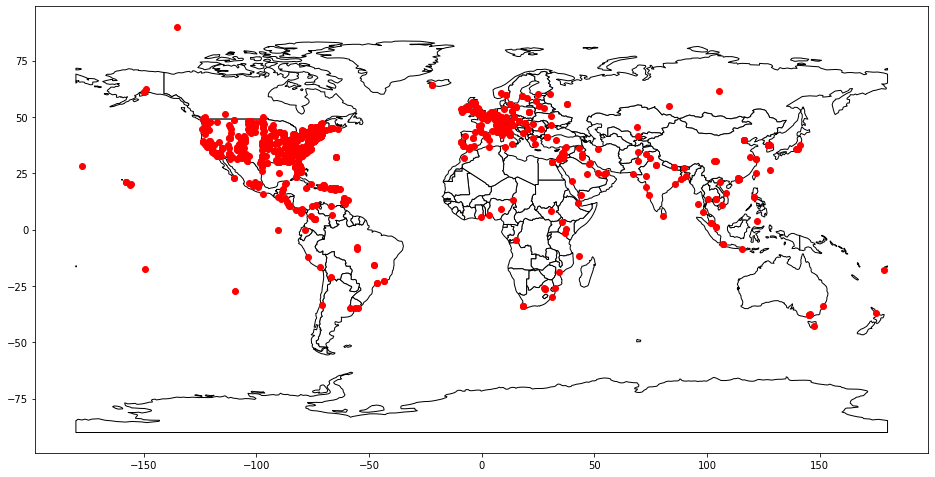

In [250]:
ax = world.plot(figsize = (16, 9), color = 'white', edgecolor = 'black')
gdf.plot(color = 'red', ax = ax)
plt.show()

## I then used Google's geocoding API to get the county, state, and country for each of the places mapped out, and filtered down to the U.S. for further analysis 


This code is similar to what we used above

```python 
place_dict = {}
for place in tqdm(df.geo.unique()): 
    try:
        res = requests.get('https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={gkey}'.format(address = place, gkey = gkey)).json()['results'][0]['geometry']['location']
        place_dict[place] = res
    except: 
        place_dict[place] = place
    finally: 
        df = pd.DataFrame(place_dict).T
```

In [25]:
# We should now have something like this 

df.head()


,lead_paragraph,headline,keywords,pub_date,news_desk,word_count,geo,lat,lng,county,state,country,year
0,WASHINGTON — The attackers assembled a bristli...,{'main': 'A Nation Wonders When Bloodshed Beco...,"[{'name': 'persons', 'value': 'Baker, Peter', ...",2015-12-03 15:28:58+00:00,National,1207.0,WASHINGTON,38.9072,-77.0369,District of Columbia,District of Columbia,United States,2015
1,WASHINGTON — The Senate on Monday voted to con...,{'main': 'Senate Confirms Gayle E. Smith as He...,"[{'name': 'persons', 'value': 'Nixon, Ron', 'r...",2015-12-01 00:46:50+00:00,National,758.0,WASHINGTON,38.9072,-77.0369,District of Columbia,District of Columbia,United States,2015
2,WASHINGTON — Frustrated by Russia’s refusal to...,{'main': 'U.S. Plans to Counter Arms Breach by...,"[{'name': 'persons', 'value': 'Gordon, Michael...",2015-12-02 02:37:03+00:00,Foreign,641.0,WASHINGTON,38.9072,-77.0369,District of Columbia,District of Columbia,United States,2015
3,WASHINGTON — As student protests over racial i...,{'main': 'Students’ Protests May Play Role in ...,"[{'name': 'organizations', 'value': 'Supreme C...",2015-12-01 21:29:37+00:00,National,1383.0,WASHINGTON,38.9072,-77.0369,District of Columbia,District of Columbia,United States,2015
4,"WASHINGTON — Family members of Glen Doherty, a...",{'main': 'Family of American Killed in Benghaz...,"[{'name': 'persons', 'value': 'Doherty, Glen A...",2015-12-02 16:11:35+00:00,National,943.0,WASHINGTON,38.9072,-77.0369,District of Columbia,District of Columbia,United States,2015


## This dataframe should include all U.S. places included in the datelines of the NYT. We're now ready to do some mapping. 

### I built the hex maps with R; my R notebooks are included in the repo as well. 

---

## Next step is to clean the headlines, keywords, and bylines. We can then do a bit of extra analysis looing at which keywords correlate with states 